In [115]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [116]:
def generate_data(sigma):
    mean_a = np.array([-1, -1])
    mean_b = np.array([1, -1])
    mean_c = np.array([0, 1])
    
    cov_a = sigma * np.array([[2, 0.5], [0.5, 1]])
    cov_b = sigma * np.array([[1, -0.5], [-0.5, 2]])
    cov_c = sigma * np.array([[1, 0], [0, 2]])
    
    cluster_a = np.random.multivariate_normal(mean_a, cov_a, 100)
    cluster_b = np.random.multivariate_normal(mean_b, cov_b, 100)
    cluster_c = np.random.multivariate_normal(mean_c, cov_c, 100)
    
    data = np.vstack((cluster_a, cluster_b, cluster_c))
    
    labels = np.array([0]*100 + [1]*100 + [2]*100)  # true labels
    
    return data, labels

sigmas = [0.5, 1, 2, 4, 8]

#print(generate_data(1))

In [117]:
def kmeans(data, k=3, max_iters=2000, tol=1e-4):
    # Randomly initialization
    centroids = data[np.random.choice(range(data.shape[0]), k, replace=False)]

    for i in range(max_iters):
        # Assign clusters
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        closest_centroids = np.argmin(distances, axis=0)

        # Re-calculate centroids
        new_centroids = np.array([data[closest_centroids == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) <= tol):
            break

        centroids = new_centroids

    return closest_centroids, centroids
    
    
def kmeans_find_best_matching(true_labels, kmeans_labels, centroids):
    
    true_means = [np.mean(data[true_labels == i], axis=0) for i in range(3)]
    
    distances = np.array([[np.linalg.norm(true_mean - centroid) for centroid in centroids] for true_mean in true_means])  
    matching = np.argmin(distances, axis=1)
    
    label_mapping = {kmeans_label: true_label for true_label, kmeans_label in enumerate(matching)}
    
    mapped_labels = np.vectorize(label_mapping.get)(kmeans_labels)
    
    accuracy = np.mean(mapped_labels == true_labels)
    
    return accuracy


def initialize_parameters(data, k):
    # Initialize means using K-means++ or random choice
    means = data[np.random.choice(range(data.shape[0]), k, replace=False)]
    # Initialize covariances to identity matrices
    covariances = [np.eye(data.shape[1]) for _ in range(k)]
    # Initialize mixing coefficients to uniform
    pis = np.ones(k) / k
    return means, covariances, pis

def e_step(data, means, covariances, pis, k):
    responsibilities = np.zeros((data.shape[0], k))
    for i in range(k):
        rv = multivariate_normal(mean=means[i], cov=covariances[i])
        responsibilities[:, i] = pis[i] * rv.pdf(data)
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(data, responsibilities, k):
    Nk = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, data) / Nk[:, np.newaxis]
    covariances = []
    for i in range(k):
        diff = data - means[i]
        covariances.append((responsibilities[:, i, np.newaxis] * diff).T @ diff / Nk[i])
    pis = Nk / data.shape[0]
    return means, covariances, pis

def gmm_em(data, k=3, max_iters=2000, tol=1e-4):
    means, covariances, pis = initialize_parameters(data, k)
    log_likelihood = 0
    for iteration in range(max_iters):
        responsibilities = e_step(data, means, covariances, pis, k)
        means, covariances, pis = m_step(data, responsibilities, k)
        # Check for convergence 
        new_log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        if np.abs(new_log_likelihood - log_likelihood) < tol:
            break
        log_likelihood = new_log_likelihood
    return means, covariances, pis, responsibilities


def negative_log_likelihood(data, means, covariances, pis, responsibilities):
    nll = 0
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        rv = multivariate_normal(mean, cov)
        nll -= np.sum(responsibilities[:, i] * np.log(pis[i] * rv.pdf(data)))
    return nll

def GMM_find_best_matching(means, true_means):
    from scipy.optimize import linear_sum_assignment
    
    cost_matrix = np.zeros((len(means), len(true_means)))
    for i, mean in enumerate(means):
        for j, true_mean in enumerate(true_means):
            cost_matrix[i, j] = np.linalg.norm(mean - true_mean)
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return row_ind, col_ind

def clustering_accuracy(labels, true_labels, row_ind, col_ind):
    mapped_labels = np.zeros_like(labels)
    for i, j in zip(row_ind, col_ind):
        mapped_labels[labels == i] = j
    return np.mean(mapped_labels == true_labels)

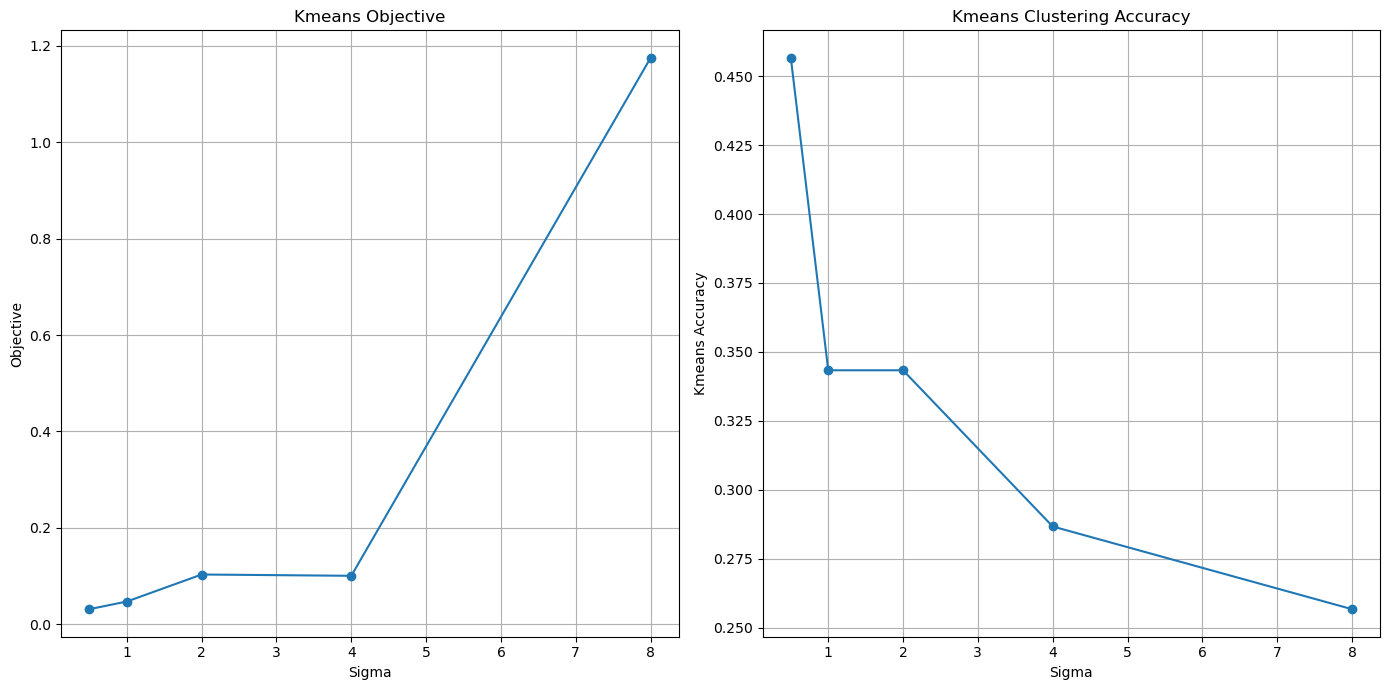

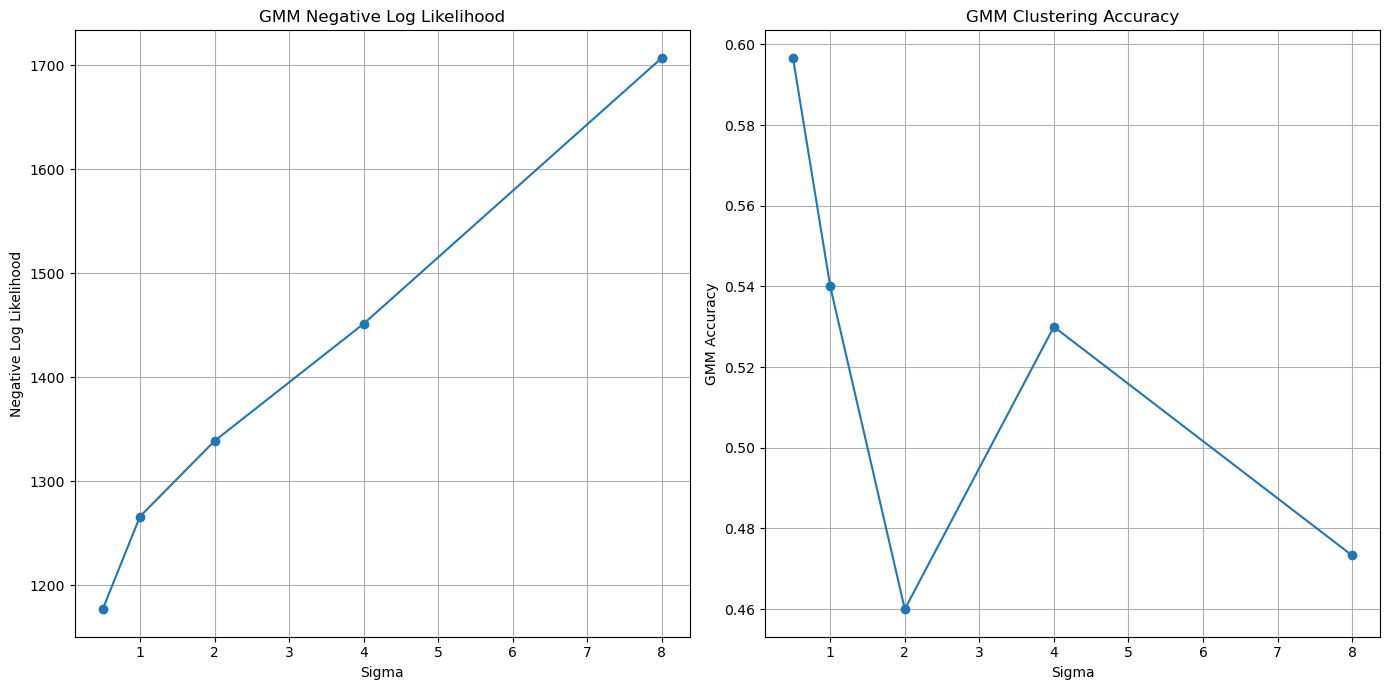

In [136]:
true_means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]

gmm_results = [] 
kmeans_objective = []
kmeans_accuracies = []

for sigma in sigmas:
    data, true_labels = generate_data(sigma)
    
    labels, centroids = kmeans(data)
    means, covariances, pis, responsibilities = gmm_em(data)

    #kmeans_objective function
    #objective = np.sum([np.linalg.norm(data[labels == j] - centroids[j], ord=2, axis=1)**2 for j in range(k)])

    objective = np.sum([np.min(np.linalg.norm(data - centroid, ord = 2, axis=1))**2 for centroid in centroids])
    kmeans_objective.append(objective)
    
    #kmeans_accurancy
    kmeans_accuracy = kmeans_find_best_matching(true_labels, kmeans_labels, centroids)
    kmeans_accuracies.append(kmeans_accuracy)
    
    #GMM_negative_log_likelihood
    nll = negative_log_likelihood(data, means, covariances, pis, responsibilities)
    
    #GMM_accurancy      
    row_ind, col_ind = GMM_find_best_matching(means, true_means)
    acc = clustering_accuracy(np.argmax(responsibilities, axis=1), true_labels, row_ind, col_ind)
    gmm_results.append((sigma, nll, acc))

    
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(sigmas, kmeans_objective, marker='o')
plt.title('Kmeans Objective')
plt.xlabel('Sigma')
plt.ylabel('Objective')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sigmas, kmeans_accuracies, marker='o')
plt.title('Kmeans Clustering Accuracy')
plt.xlabel('Sigma')
plt.ylabel('Kmeans Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


sigmas, nlls, accs = zip(*gmm_results)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(sigmas, nlls, marker='o')
plt.title('GMM Negative Log Likelihood')
plt.xlabel('Sigma')
plt.ylabel('Negative Log Likelihood')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sigmas, accs, marker='o')
plt.title('GMM Clustering Accuracy')
plt.xlabel('Sigma')
plt.ylabel('GMM Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


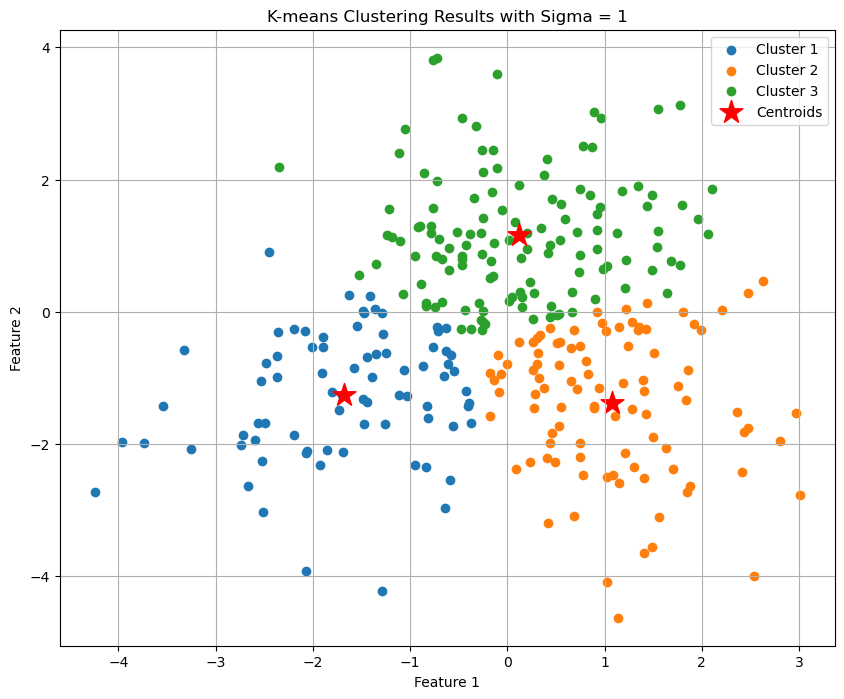

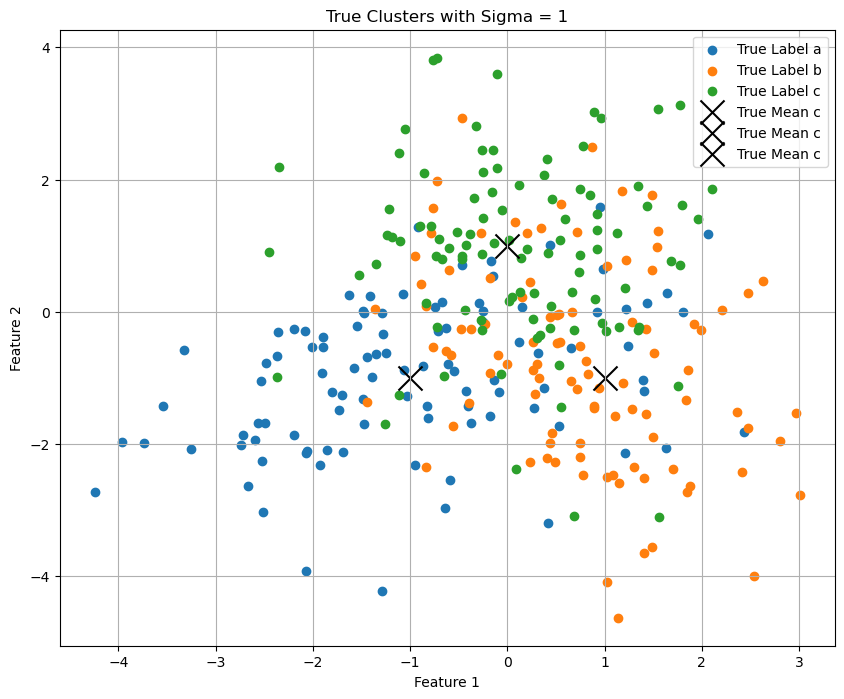

[0.31333333333333335, 0.2866666666666667, 0.25666666666666665, 0.2866666666666667, 0.3433333333333333, 0.31333333333333335]


In [114]:
import matplotlib.pyplot as plt
import numpy as np

# use sigma = 1 to see the result
data, true_labels = generate_data(sigma=1)

def kmeans(data, k=3, max_iters=2000, tol=1e-4):

    centroids = data[np.random.choice(range(data.shape[0]), k, replace=False)]
    labels = np.zeros(data.shape[0])

    for i in range(max_iters):
        # Assign clusters
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        new_labels = np.argmin(distances, axis=0)

        # Re-calculate centroids
        new_centroids = np.array([data[new_labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.all(new_labels == labels):
            break

        labels = new_labels
        centroids = new_centroids

    return labels, centroids

# Running K-means with sigma = 1
labels, centroids = kmeans(data)

# Now, let's plot the results
plt.figure(figsize=(10, 8))

# Plot each cluster
for i in range(3):
    # Plot data points associated with each cluster
    cluster_data = data[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids', marker='*')

plt.title('K-means Clustering Results with Sigma = 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Plot for true labels
plt.figure(figsize=(10, 8))

# Plot each true cluster
for i, mean in enumerate([[-1, -1], [1, -1], [0, 1]]):
    # Plot data points associated with each true label
    cluster_data = data[true_labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'True Label {chr(97+i)}')

# Plot the true means as black x's
for mean in [[-1, -1], [1, -1], [0, 1]]:
    plt.scatter(mean[0], mean[1], s=300, c='black', label=f'True Mean {chr(97+i)}', marker='x')

plt.title('True Clusters with Sigma = 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

kmeans_accuracy = kmeans_find_best_matching(true_labels, kmeans_labels, centroids)
kmeans_accuracies.append(kmeans_accuracy)
print(kmeans_accuracies)